In [2]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy
from functools import *

In [3]:
def real(oper):
    return (oper+oper.conj())/2
def imag(oper):
    return (oper-oper.conj())/2

In [4]:
k = 1
w    = [5*2*np.pi*k,6.1*2*np.pi*k]   #w[i] is transition frequency of qubit [i] 
wxx  = 0.02*2*np.pi*k  #wxx is coupling energy
f    = [0.05*2*np.pi*k,0] #f[i] is amplitude of microwave signal applied to qubit [i] 3
w_rf = [w[1], 0]  #w_rf[i] is frequency of --//--
phi  = [0, 0]  #phi[i] is phase of --//--
N    = [2,2]   #2lvls approximation

a = 0
t_gate = 1*np.pi/wxx/f[0]*abs(w[0]-w[1])
b = t_gate
st = 0.01

args = {'a':a, 'b':b,'st':st, 'w_rf':w_rf[0],'phi':phi[0]}

time_coeff = "cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
tlist_t = b
timesteps = 500
tlist = np.linspace(0,tlist_t,timesteps)

### Operators

In [5]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, identity(N[1]))
    else:
        return tensor(identity(N[0]), oper)
def THq(qubit,w = w):
    return 0.5*w[qubit-1]*T(sigmaz(),qubit)
def THint(wxx = wxx):
    return 0.5*wxx*tensor(sigmax(), sigmax())
def THf(qubit, ff=None):
    return (f[qubit-1] if ff==None else ff)*T(sigmax(),qubit)
def THsys_t(ff=f[0]):
    return [THq(1) + THq(2) + THint(),[THf(1,ff), time_coeff]]
anh = abs(w[0] - w[1])
def THsys_t_new(ff = f[0],wxx=wxx):
    return wxx/4*(1/(1+anh**2/ff**2))*(1*tensor(sigmax(),sigmax()) + anh/ff*tensor(sigmaz(),sigmax()))

def TSx(qubit, N = N):
    return T(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T(sigmam(),qubit, N)

In [6]:
ZX = (+0.5*1j*1/2*np.pi*tensor(sigmaz(),sigmax())).expm()
ZI = (0.5*1j*(+1/2)*np.pi*tensor(sigmaz(),identity(2))).expm()
IX = (-0.5*1j*(+1/2)*np.pi*tensor(identity(2),sigmax())).expm()

### Visual

In [7]:
def Tvis_out(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(9,2*graphs), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    colors = ["r","g","b","black","black","black","black","black","black"]
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx],linewidth=(2.5 if idy else 1.0),color=colors[idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) )
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            if idy == 1:
                ax.legend(bbox_to_anchor = [1,0],loc = "lower right")
            else:
                ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
            if idx == graphs-1:
                ax.set_xlabel('Time')
            
def Tvis_out_print(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes = plt.subplots(1,2, figsize=(13,5), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx in range(graphs):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')
                        

In [8]:
expected = []
Tpsi0 = tensor(basis(2,1), basis(2,1))
#Tpsi0 = tensor(basis(2,0)+basis(2,1), (basis(2,0) + basis(2,1)))/2
#t_gate = 1*np.pi/wxx/f[0]*abs(w[0]-w[1])
tlist = np.linspace(0,t_gate,timesteps)
gamma = 0.02
def collapse_list(g = gamma):
    if g > 0:
        return [np.sqrt(g) * (tensor(sigmap().dag(),identity(2)) + tensor(identity(2), sigmap().dag()))]
    return []
def solve(expected_ops , Tpsi_0 =Tpsi0, with_progress_bar = None):
    if with_progress_bar:
        print(THsys_t())
        return mesolve(THsys_t_new(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=100000,rhs_reuse = True), progress_bar=True)
    else:
        print(THsys_t())
        return mesolve(THsys_t_new(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=100000,rhs_reuse = True), progress_bar=None)

In [9]:
def count_gate( f):
    Tpsi = [tensor(basis(2,1), basis(2,1)), tensor(basis(2,1), basis(2,0)), tensor(basis(2,0), basis(2,1)), tensor(basis(2,0), basis(2,0))]
    Tpsi = list(reversed(Tpsi))
    #print(Tpsi)
    result = []
    f_n = f
    f_n = 1/(1+anh**2/f**2)*anh/f*anh
    t_gate = 1*np.pi/wxx/f_n*abs(w[0]-w[1])
    print(t_gate)
    args['b'] = t_gate
    tlist = np.linspace(0,t_gate,2)
    for psi_id, Tpsi0 in enumerate(Tpsi):
        #print(THsys_t(f))
        out = mesolve(THsys_t_new(f), Tpsi0, tlist, collapse_list(),[] , args = args,options= Options(nsteps=1000000,rhs_reuse = True), progress_bar=None)
        state_final = out.states[-1]
        #print(state_final)
        res_state = []
        #print(state_final)

        for Tpsi1 in Tpsi:
            res_state.append((Tpsi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    gate = Qobj(result).trans()
    return gate,t_gate
def count_fidelity(ideal_gate, gate):
    gate.dims = ideal_gate.dims
    return fidelity(ideal_gate, gate)/ideal_gate.shape[0]

In [10]:
def count_fidelity_relax(ideal_gate,f,relax,wx=wxx):
    Tpsi = [tensor(basis(2,1), basis(2,1)), tensor(basis(2,1), basis(2,0)), tensor(basis(2,0), basis(2,1)), tensor(basis(2,0), basis(2,0))]
    Tpsi = list(reversed(Tpsi))
    #print(Tpsi)
    result = []
    f_n = f
    f_n = 1/(1+anh**2/f**2)*anh/f*anh
    t_gate = 1*np.pi/wx/f_n*abs(w[0]-w[1])
    #print(t_gate)
    args['b'] = t_gate
    tlist = np.linspace(0,t_gate,2)
    #sgm_list = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
    fid = 0
    for psi_id, Tpsi0 in enumerate(Tpsi):
        #print(THsys_t(f))
        out = mesolve(THsys_t_new(f,wx), Tpsi0, tlist, collapse_list(relax),[] , args = args,options= Options(nsteps=1000000,rhs_reuse = True), progress_bar=None)
        state_final = out.states[-1]
        #print(state_final)
        res_state = []
        #print(state_final)
        rho_initial = Tpsi0*Tpsi0.dag()
        #print(rho_initial,ideal_gate)
        ideal_evolution = ideal_gate.dag()*rho_initial*ideal_gate
        fid += fidelity(ideal_evolution,state_final)
    fid /= len(Tpsi)
    return fid,t_gate

In [11]:
def t_to_f(t):
    return np.pi/wxx/t*abs(w[0]-w[1])

In [12]:
fid, time = count_fidelity_relax(ZX,0.5,0.6e-3)

In [13]:
fid,time

(0.9150219451333685, 347.3837707936485)

In [16]:
fs = np.linspace(10,0.1*2*np.pi,100)
fidsR = []
timesR = []
fids = []
times = []
for f in fs:
    fid, time = count_fidelity_relax(ZX, f,1.5e3**(-1))
    fidsR.append(fid)
    timesR.append(time)
for f in fs:
    fid, time = count_fidelity_relax(ZX, f,1.5e20**(-1))
    fids.append(fid)
    times.append(time)
bestFid = []

In [382]:
def for_solver_gen(wxx):
    def for_solver(fa):
        if fa[0] < 0 :
            return 1
        fid_r = count_fidelity_relax(ZX, fa[0], 1.5e3**(-1),wxx)[0]
        #print(fid_r)
        return 1 - fid_r
    return for_solver

In [378]:
from scipy.optimize import fsolve

In [385]:
wxx_list = np.linspace(0.001,abs(w[0]-w[1])/10, 100)
bestfid = []
for it,wx in enumerate(wxx_list):
    optf = fsolve(for_solver_gen(wxx), [1])
    bestfid.append(count_fidelity_relax(ZX,optf[0],1.5e3**(-1),wx)[0])
    print(it)

/home/safoex/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [387]:
bestfid[-1]

0.9802208080090841

In [381]:
optf = fsolve(for_solver_gen(wxx), [1])

0.9460919890706958
0.9460919890706958
0.9460919890706958
0.9460919882717962
0.9479313477048289
0.9479313482974256
0.9487439861513857
0.9501778395364104
0.9523817510637914
0.9547221974571855
0.9538162132419903
0.9523817510637914
0.9547221988913329
0.9550592615415057
0.9551120750545625
0.95509372312235
0.9550948224779313
0.9551120713377372
0.9551099269299315
0.9551128465675494
0.9551138035101693
0.955113361827921
0.9551128465675494
0.9551138072381948
0.9551139864130421


/home/safoex/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [384]:
optf[0]

1.6393959425364446

In [17]:
fidsR[np.argmax(fidsR)], timesR[np.argmax(fidsR)]

(0.9551009314064377, 109.52865968488767)

In [18]:
bf = fidsR[np.argmax(fidsR)]
bt = timesR[np.argmax(fidsR)]

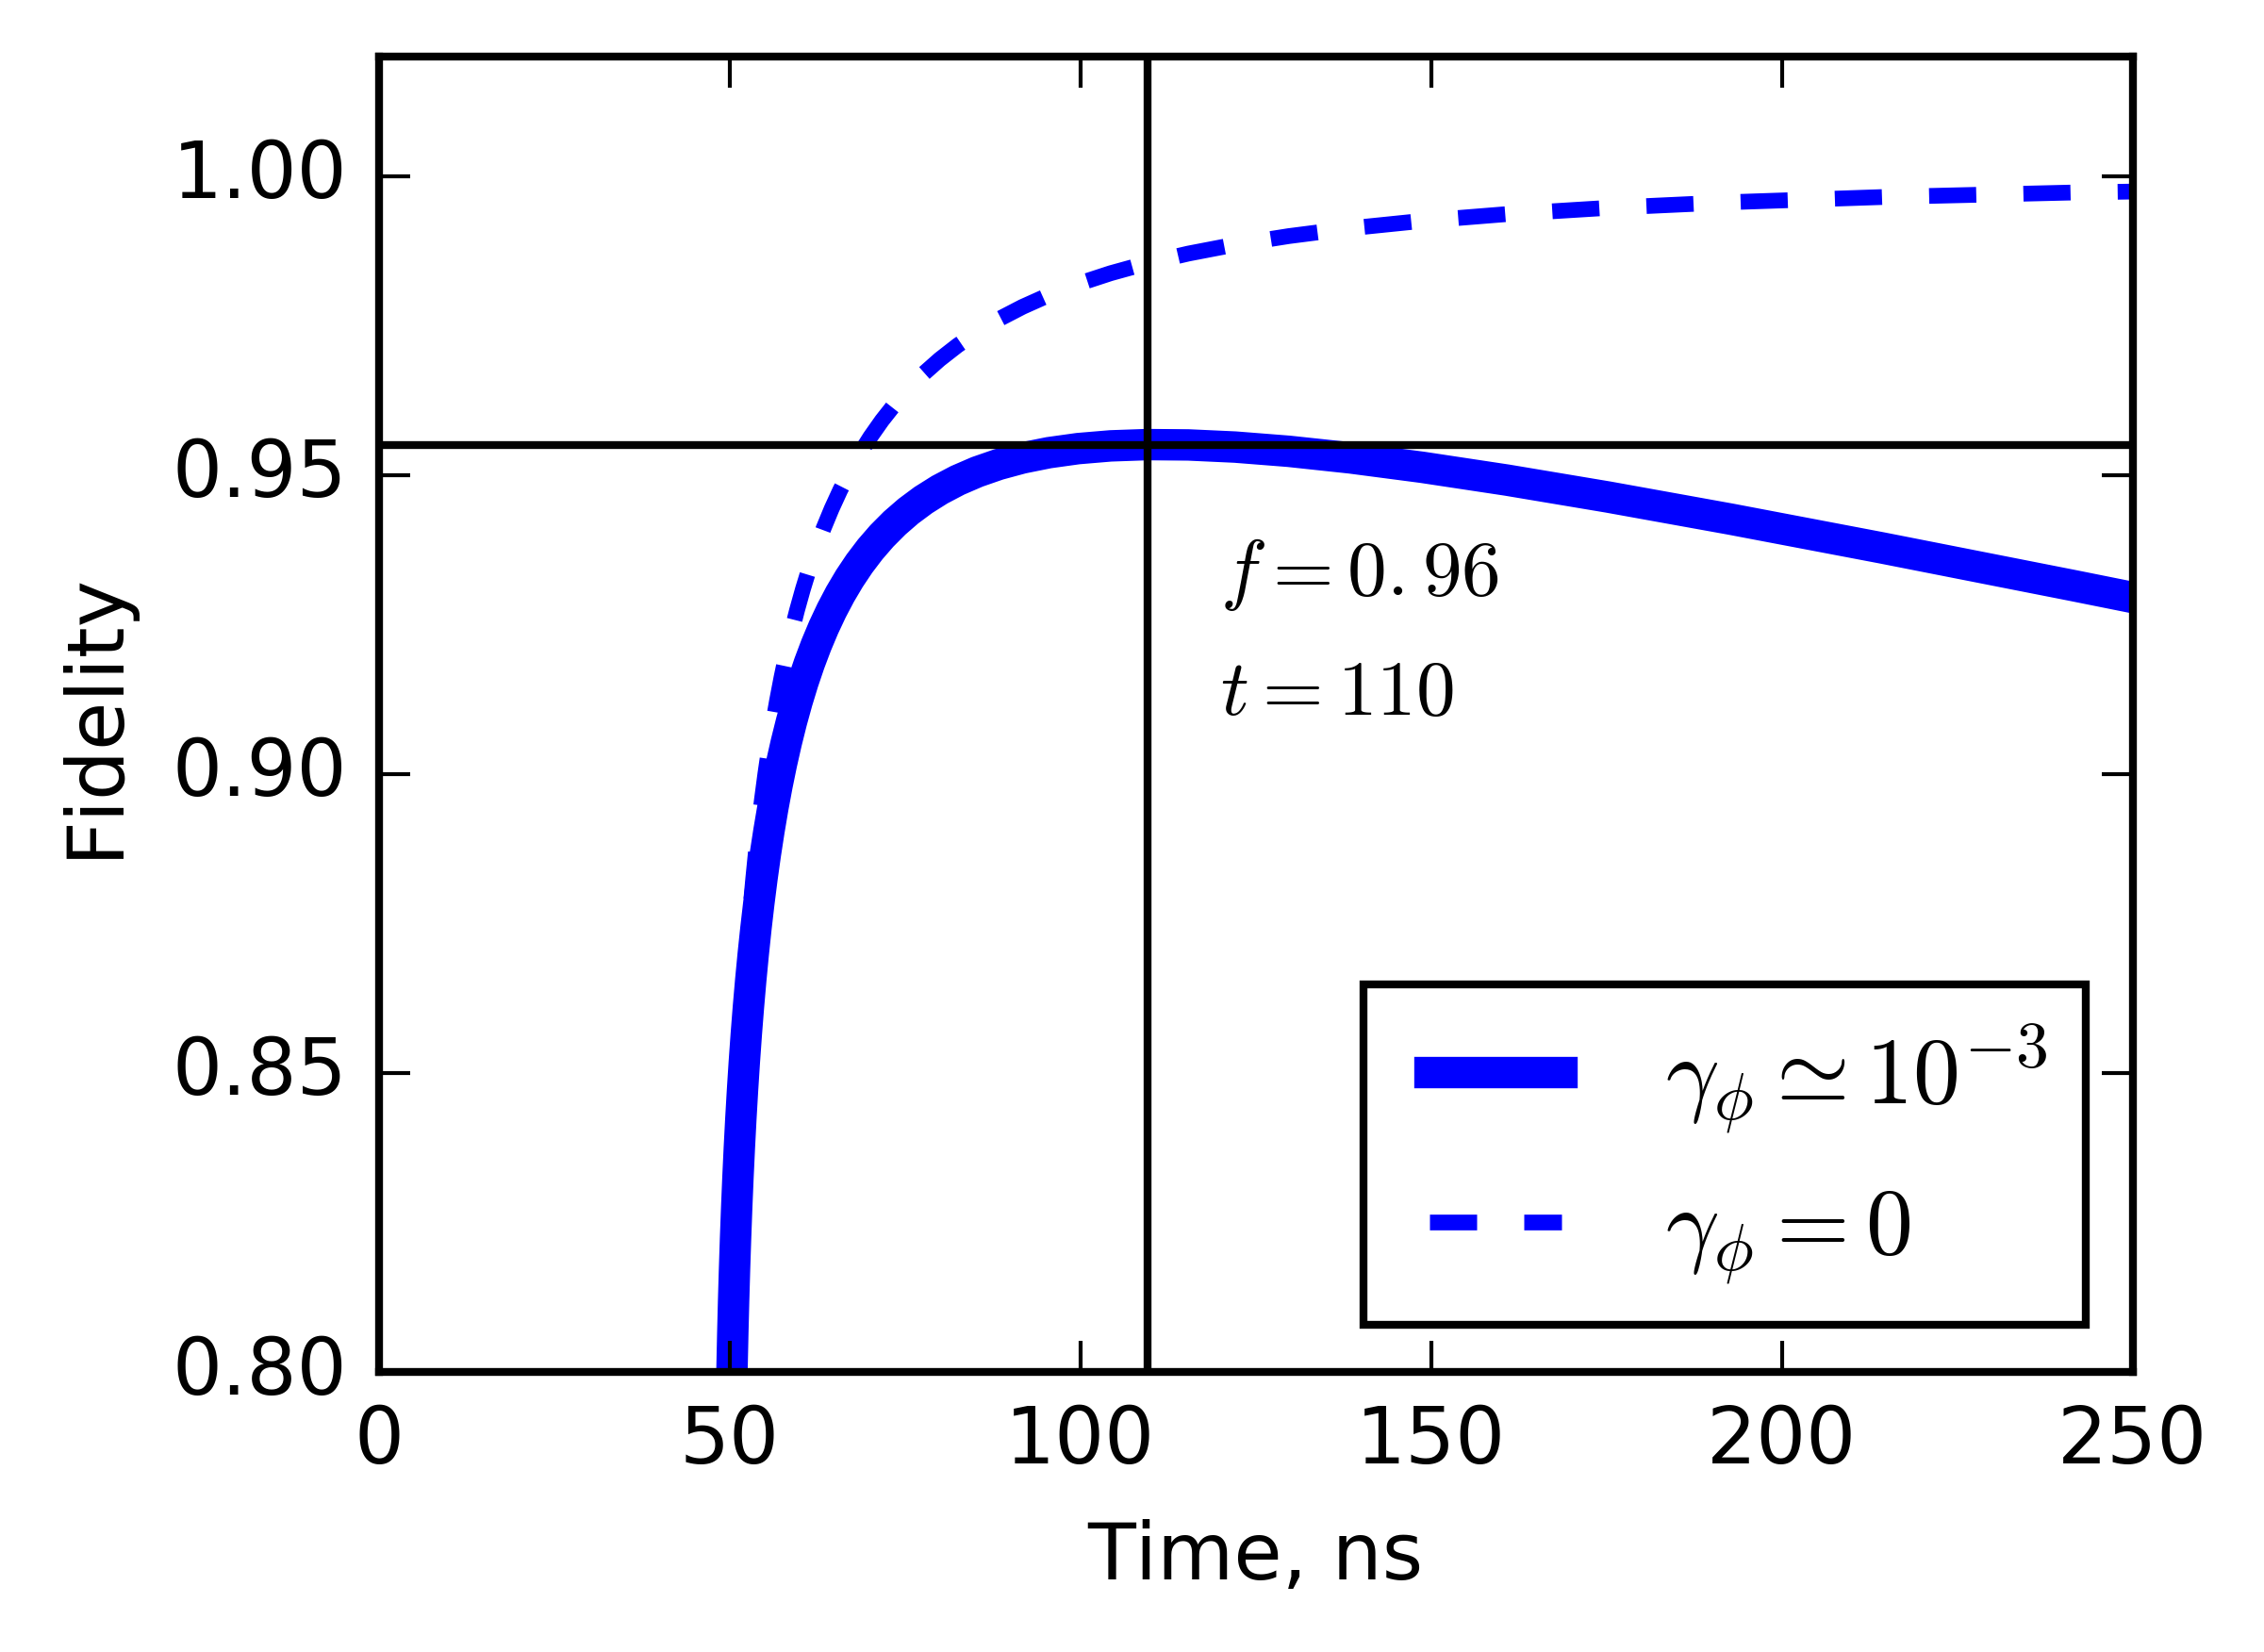

In [38]:
fig,ax = plt.subplots(1,figsize = (4,3), dpi = 600)
ax.plot(timesR,  fidsR, linewidth = 4,label = r"$\gamma_\phi \simeq 10^{-3}$")
ax.plot(times, fids,'b--', linewidth = 2, label = r"$\gamma_\phi = 0$")
#ax.plot(timesN,np.ones_like(fidsN) - fidsN, linewidth = 4)
#ax.plot(times, np.ones_like(times), 'r--', linewidth = 2)
ylim = [0.8,1.02]
xlim = [0,250]
ax.plot(xlim, bf*np.ones_like(xlim), 'black')
ax.plot(bt*np.ones_like(ylim),ylim,'black')
ax.set_ylim([0.8,1.02])
ax.set_xlim([0,250])
ax.text(120,0.93,r'$f = 0.96$' , fontsize = "10")
ax.text(120,0.91,r'$t = 110$' , fontsize = "10")
ax.set_xlabel('Time, ns')
ax.set_ylabel('Fidelity')
ax.legend(loc = 'lower right')
plt.savefig("CNOT_fidelity_time.pdf", bbox_inches = 'tight')

In [275]:
np.argmax(fidsR)

90

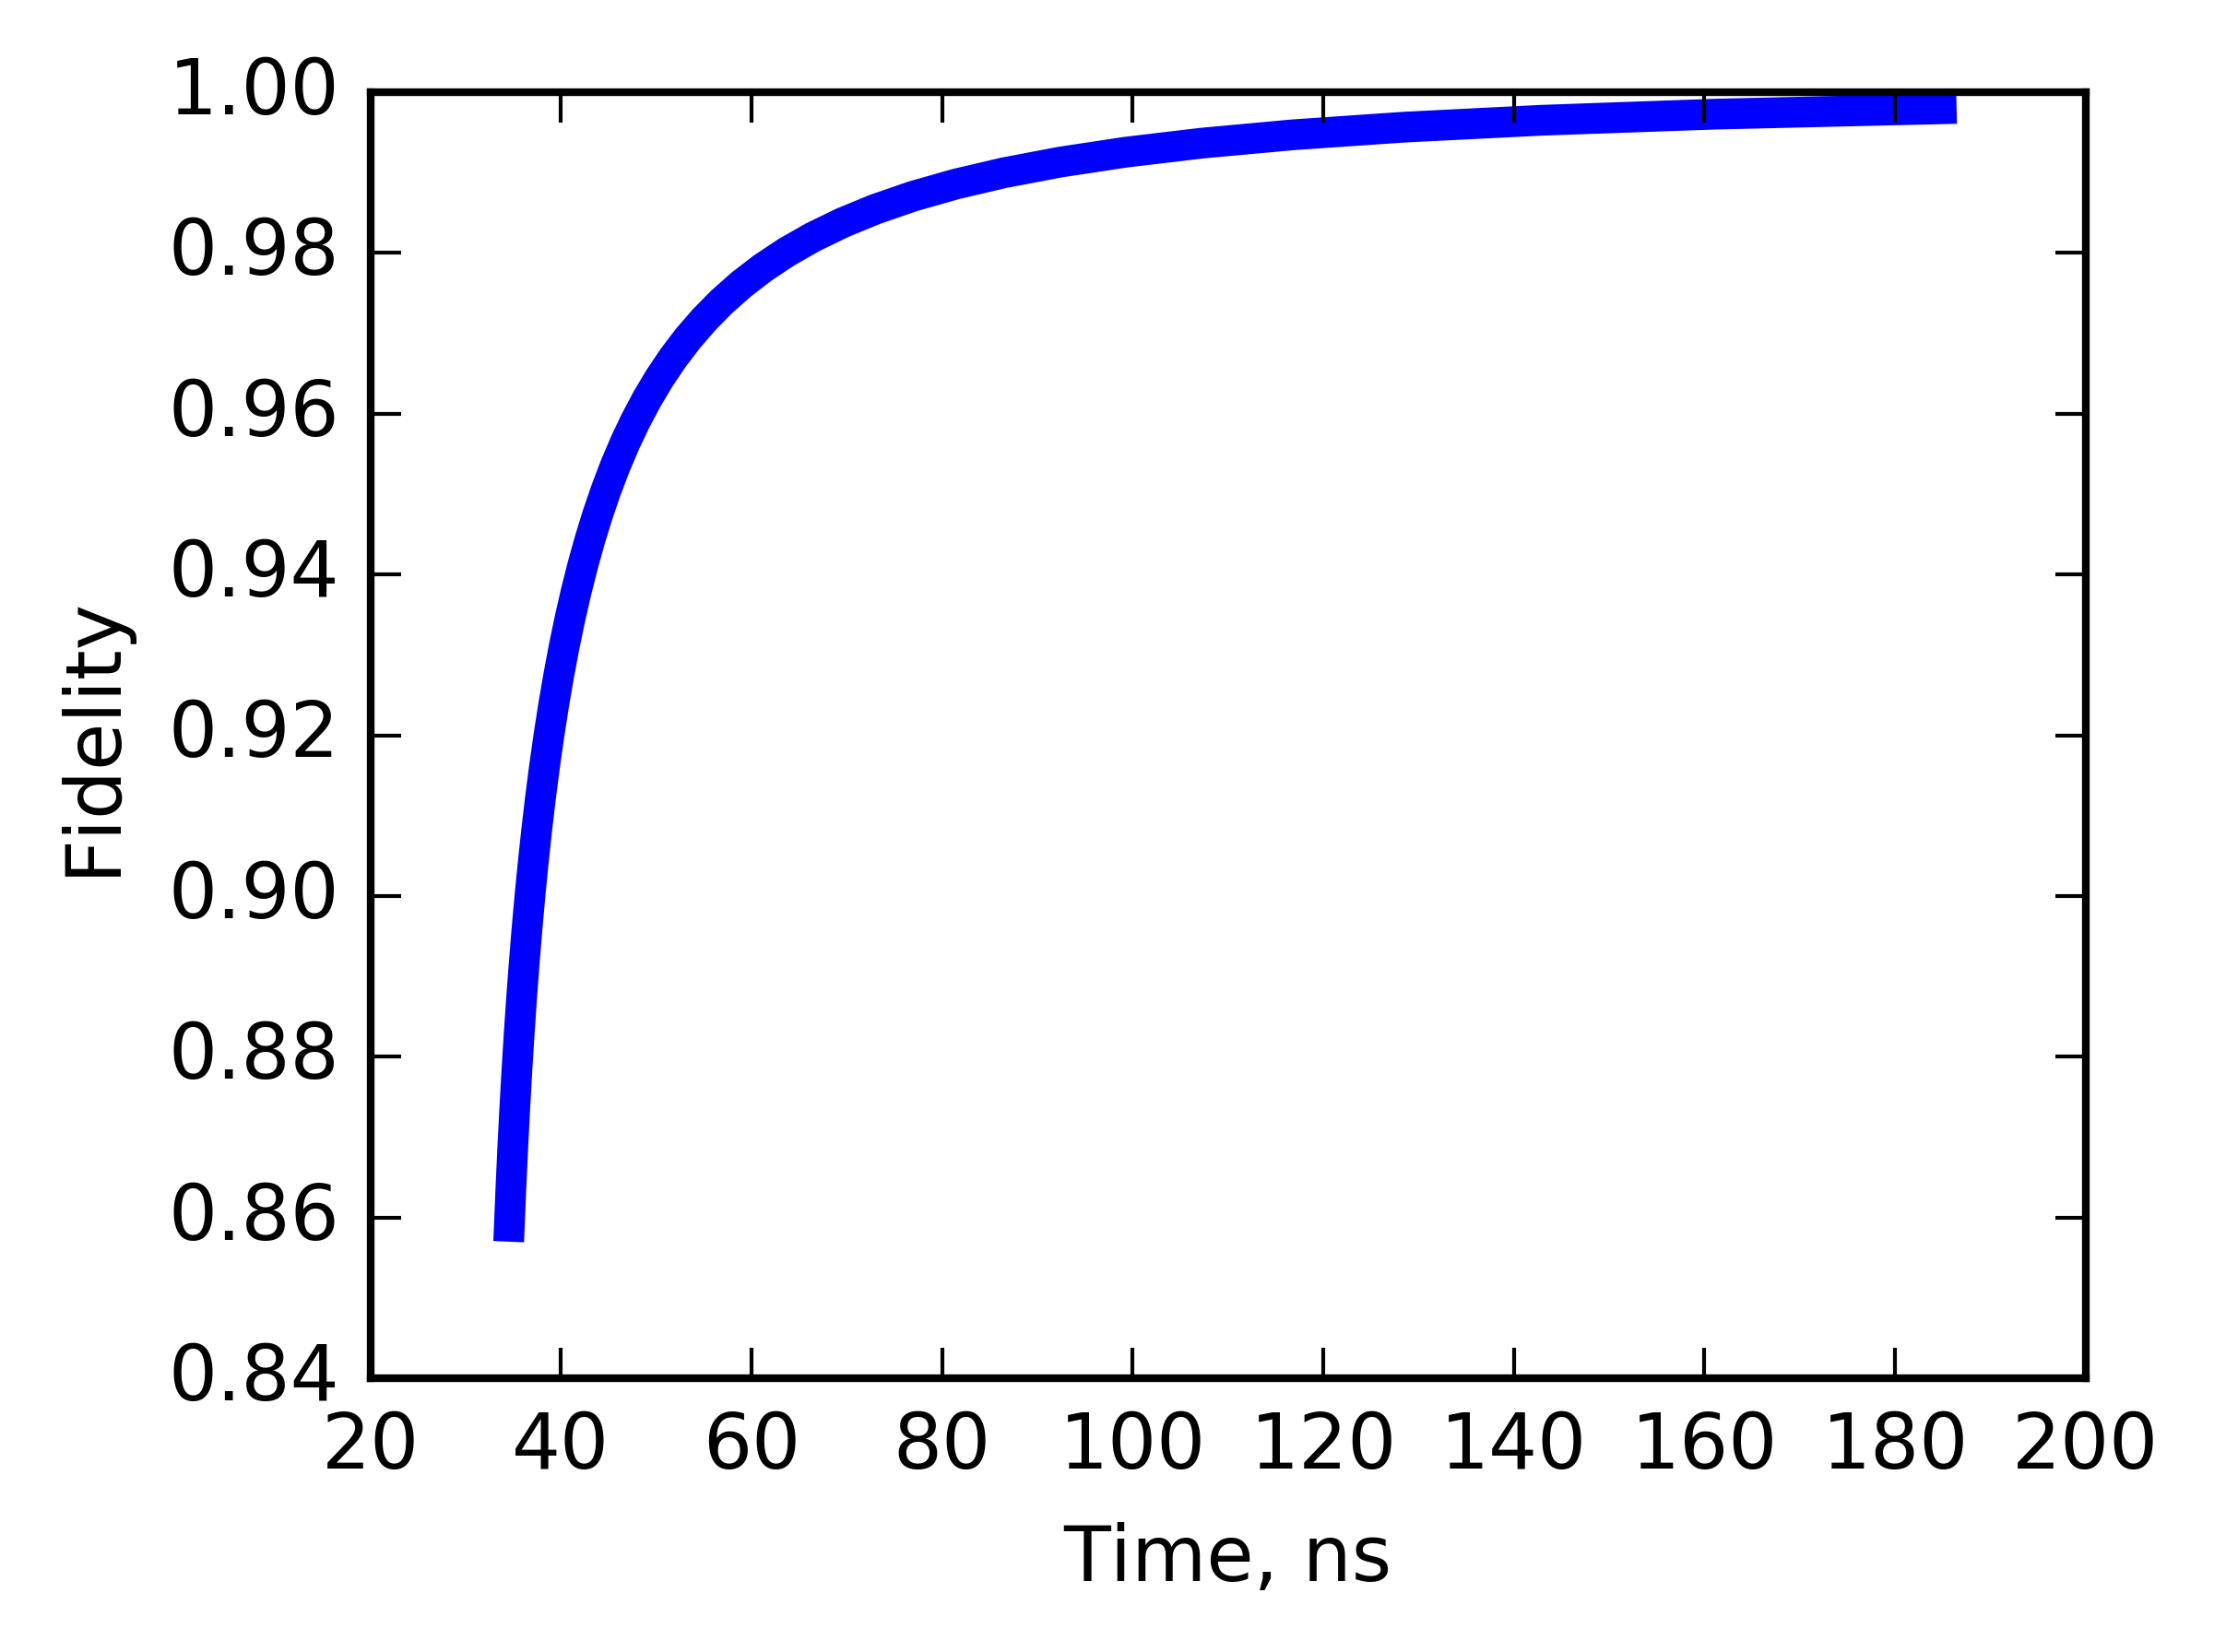

In [243]:
fig,ax = plt.subplots(1,figsize = (4,3), dpi = 600)
ax.plot(times[50:],  fids[50:], linewidth = 4)
#ax.plot(timesN,np.ones_like(fidsN) - fidsN, linewidth = 4)
#ax.plot(times, np.ones_like(times), 'r--', linewidth = 2)
#ax.set_ylim([0.75,1.05])
#ax.set_xlim([10,35])
ax.set_xlabel('Time, ns')
ax.set_ylabel('Fidelity')

In [38]:
t_gate

366.6666666666665

In [39]:
gate.dims = ZX.dims
fidelity(ZX,gate)/4

0.9690873574416968

### Graphs

In [19]:
def observe(output, operators, rotationFreq , every = 1):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time, state in zip(tlist[::every], output.states[::every]):
#         time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

def observe_last(output, operators, rotationFreq):
    expectation = []
    time = tlist[-1]
    state = output.states[-1]
    for i, op in enumerate(operators):
        for qubit in [1,2]:
            if rotationFreq[qubit-1] != 0:
                U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                TU = T(U,qubit)
                expectation[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
            else:
                expectation[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return expectation

In [20]:
#t_gate = 355.01630
#t_gate = 1*np.pi/wxx/f[0]*abs(w[0]-w[1])
args['a'] = 0
args['b'] = args['a'] + t_gate
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
out = solve([])

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 34.87167845   0.           0.           0.09424778]
 [  0.          -3.45575192   0.09424778   0.        ]
 [  0.           0.09424778   3.45575192   0.        ]
 [  0.09424778   0.           0.         -34.87167845]], [Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.31415927  0.        ]
 [ 0.          0.          0.          0.31415927]
 [ 0.31415927  0.          0.          0.        ]
 [ 0.          0.31415927  0.          0.        ]], 'cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))']]


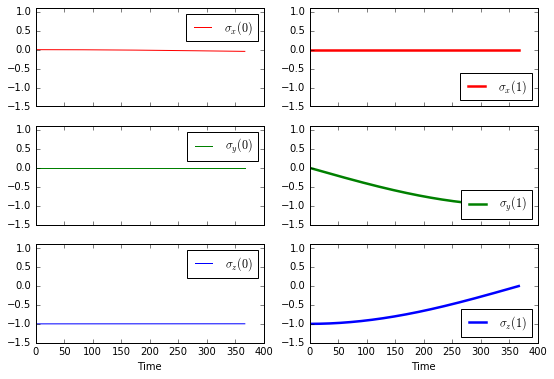

In [23]:
output2 = observe(out, [TSx, TSy, TSz], [0,0],1)
Tvis_out(output2,1)